Clone into the repository to gain acces to the uci datasets

In [163]:
!git clone https://github.com/DavidSommer94/dagstuhl

fatal: destination path 'dagstuhl' already exists and is not an empty directory.


First, we have to install gpytorch which is pytorch's module containing Gaussian processes.



In [164]:
import torch
torch.set_default_dtype(torch.double)

In [165]:
!pip install gpytorch

In [172]:
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import MeanFieldVariationalDistribution
from gpytorch.variational import VariationalStrategy

import math

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = MeanFieldVariationalDistribution(num_inducing_points=inducing_points.shape[0])
        variational_strategy = VariationalStrategy(
            model=self,
            inducing_points=inducing_points,
            variational_distribution=variational_distribution,
            learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_func = gpytorch.means.ConstantMean()
        self.covariance_func = gpytorch.kernels.RBFKernel(lengthscale=10.)

    def forward(self, data):
        mean = self.mean_func(data)
        covariance = self.covariance_func(data)

        return gpytorch.distributions.MultivariateNormal(mean=mean, covariance_matrix=covariance)


Next we load the real data examples from the uci set.

In [173]:
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from scipy.io import loadmat
from math import floor

In [174]:
# 45730 Data points of 9 attributes/dimensions each  
data_set = loadmat('/content/dagstuhl/uci/protein.mat')['data']
data = data_set[:, :-1]        
data = (data - data.min(0)[0]) / (data.max(0)[0] - data.min(0)[0]) # normalize data on [0,1]
target = data_set[:, -1]


# # 48827 Data points of 20 attributes/dimensions each 
# data_set = loadmat('/content/dagstuhl/uci/keggdirected.mat')['data']
# data = data_set[:, :-1]
# data = (data - data.min(0)[0]) / (data.max(0)[0] - data.min(0)[0])
# target = data_set[:, -1]

# # 40000 Data points of 8 attributes/dimensions each 
# data_set = loadmat('/content/dagstuhl/uci/kin40k.mat')['data']
# data = data_set[:, :-1]
# data = (data - data.min(0)[0]) / (data.max(0)[0] - data.min(0)[0])
# target = data_set[:, -1]

def create_toy_data(func, n=1000, std=1., domain=[0., 1.]):
    x = np.linspace(domain[0], domain[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

data, target = create_toy_data(sinusoidal, n=100, std=.1, domain=[0., 1.])
data = data[:,None]
data_set = (data, target)
print(data.shape)
print(target.shape)

(100, 1)
(100,)


Define the training of the model.

In [175]:
num_train = int(floor(0.7 * len(data)))
num_val = int(floor(0.15 * len(data)))

dtype=torch.double
train_data = torch.as_tensor(data[: num_train, :], dtype=dtype)
train_target = torch.as_tensor(target[:num_train], dtype=dtype)
# train_loader = DataLoader(dataset=TensorDataset(train_data, train_target), batch_size=train_data.shape[0])

test_data = torch.as_tensor(data[num_train:num_train + num_val, :], dtype=dtype)
test_target = torch.as_tensor(target[num_train:num_train + num_val], dtype=dtype)

train_dataloader = DataLoader(dataset=TensorDataset(train_data, train_target), batch_size=1000)
test_dataloader = DataLoader(dataset=TensorDataset(test_data, test_target), batch_size=1000)

In [176]:
def train_loop(model, dataloader, loss_fn, optimizer):
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(model, dataloader, loss_fn):
    total_samples = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return correct/total_samples, test_loss / total_samples

In [177]:
import torch.nn as nn
from torch.optim import Adam

device = torch.device('cpu')
config = dict(
        gp_lr=1e-3,
        num_ind_points=100
    )

inducing_points = torch.rand((config['num_ind_points'], train_dataloader.dataset[0][0].shape[0]))

model = GPModel(inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

optimizer = Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
    ],
    lr=config['gp_lr'],
    weight_decay=0.
)

elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_dataloader.dataset)).to(device)
objective = nn.MSELoss(reduction='mean').to(device)

loss_fn = nn.CrossEntropyLoss()

def train_loop(model, dataloader, loss_fn, optimizer, verbose=False):
    for X, y in dataloader:
        pred = model(X)
        loss = -elbo(pred, y)
        
        optimizer.zero_grad()
        loss.backward()

        if verbose:
          print('Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
          loss.item(),
          model.covariance_func.lengthscale,
          likelihood.noise
          ))
        optimizer.step()

def test_loop(model, dataloader, loss_fn):
    total_samples = len(dataloader.dataset)
    test_loss = 0.
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += objective(pred.mean, y).item()
    return test_loss / total_samples

In [178]:
from tqdm import trange

epochs = 1000
with trange(epochs) as pbar:
    for t in pbar:
        train_loop(model, train_dataloader, loss_fn, optimizer, verbose=True)
        mse = test_loop(model, test_dataloader, loss_fn)
        pbar.set_description(f"Epoch {t+1}")
        pbar.set_postfix(MSE=mse)

avg_loss = test_loop(model, test_dataloader, loss_fn)
print(f"Done! MSE: {mse:f}")


Epoch 8:   0%|          | 5/1000 [00:00<00:24, 40.38it/s, MSE=0.0641]

Loss: 1.780   lengthscale: 0.693   noise: 0.693
Loss: 1.777   lengthscale: 0.694   noise: 0.694
Loss: 1.774   lengthscale: 0.694   noise: 0.694
Loss: 1.771   lengthscale: 0.693   noise: 0.695
Loss: 1.768   lengthscale: 0.693   noise: 0.695
Loss: 1.765   lengthscale: 0.693   noise: 0.696
Loss: 1.762   lengthscale: 0.692   noise: 0.696
Loss: 1.759   lengthscale: 0.692   noise: 0.697
Loss: 1.756   lengthscale: 0.691   noise: 0.697


Epoch 17:   2%|▏         | 15/1000 [00:00<00:24, 40.72it/s, MSE=0.0655]

Loss: 1.754   lengthscale: 0.691   noise: 0.698
Loss: 1.751   lengthscale: 0.690   noise: 0.698
Loss: 1.748   lengthscale: 0.690   noise: 0.699
Loss: 1.745   lengthscale: 0.689   noise: 0.699
Loss: 1.742   lengthscale: 0.689   noise: 0.700
Loss: 1.740   lengthscale: 0.688   noise: 0.700
Loss: 1.737   lengthscale: 0.688   noise: 0.701
Loss: 1.734   lengthscale: 0.687   noise: 0.701
Loss: 1.731   lengthscale: 0.687   noise: 0.702


Epoch 27:   2%|▎         | 25/1000 [00:00<00:23, 41.74it/s, MSE=0.067] 

Loss: 1.729   lengthscale: 0.686   noise: 0.702
Loss: 1.726   lengthscale: 0.685   noise: 0.703
Loss: 1.723   lengthscale: 0.685   noise: 0.703
Loss: 1.721   lengthscale: 0.684   noise: 0.704
Loss: 1.718   lengthscale: 0.684   noise: 0.704
Loss: 1.715   lengthscale: 0.683   noise: 0.705
Loss: 1.713   lengthscale: 0.683   noise: 0.705
Loss: 1.710   lengthscale: 0.682   noise: 0.706
Loss: 1.707   lengthscale: 0.681   noise: 0.706


Epoch 35:   4%|▎         | 35/1000 [00:00<00:24, 38.71it/s, MSE=0.068]

Loss: 1.705   lengthscale: 0.681   noise: 0.707
Loss: 1.702   lengthscale: 0.680   noise: 0.707
Loss: 1.699   lengthscale: 0.679   noise: 0.708
Loss: 1.697   lengthscale: 0.679   noise: 0.708
Loss: 1.694   lengthscale: 0.678   noise: 0.709
Loss: 1.692   lengthscale: 0.678   noise: 0.709
Loss: 1.689   lengthscale: 0.677   noise: 0.710
Loss: 1.687   lengthscale: 0.676   noise: 0.710


Epoch 43:   4%|▍         | 43/1000 [00:01<00:24, 38.42it/s, MSE=0.0689]

Loss: 1.684   lengthscale: 0.676   noise: 0.711
Loss: 1.682   lengthscale: 0.675   noise: 0.711
Loss: 1.679   lengthscale: 0.674   noise: 0.711
Loss: 1.677   lengthscale: 0.674   noise: 0.712
Loss: 1.674   lengthscale: 0.673   noise: 0.712
Loss: 1.672   lengthscale: 0.672   noise: 0.713
Loss: 1.669   lengthscale: 0.672   noise: 0.713
Loss: 1.667   lengthscale: 0.671   noise: 0.714


Epoch 50:   5%|▍         | 47/1000 [00:01<00:24, 38.44it/s, MSE=0.0695]

Loss: 1.664   lengthscale: 0.670   noise: 0.714
Loss: 1.662   lengthscale: 0.670   noise: 0.715
Loss: 1.659   lengthscale: 0.669   noise: 0.715
Loss: 1.657   lengthscale: 0.668   noise: 0.716
Loss: 1.654   lengthscale: 0.667   noise: 0.716
Loss: 1.652   lengthscale: 0.667   noise: 0.717
Loss: 1.650   lengthscale: 0.666   noise: 0.717
Loss: 1.647   lengthscale: 0.665   noise: 0.718


Epoch 59:   6%|▌         | 59/1000 [00:01<00:26, 35.99it/s, MSE=0.07]

Loss: 1.645   lengthscale: 0.665   noise: 0.718
Loss: 1.643   lengthscale: 0.664   noise: 0.718
Loss: 1.640   lengthscale: 0.663   noise: 0.719
Loss: 1.638   lengthscale: 0.662   noise: 0.719
Loss: 1.635   lengthscale: 0.662   noise: 0.720
Loss: 1.633   lengthscale: 0.661   noise: 0.720
Loss: 1.631   lengthscale: 0.660   noise: 0.721
Loss: 1.628   lengthscale: 0.659   noise: 0.721


Epoch 67:   7%|▋         | 67/1000 [00:01<00:25, 36.57it/s, MSE=0.0703]

Loss: 1.626   lengthscale: 0.659   noise: 0.722
Loss: 1.624   lengthscale: 0.658   noise: 0.722
Loss: 1.621   lengthscale: 0.657   noise: 0.722
Loss: 1.619   lengthscale: 0.656   noise: 0.723
Loss: 1.617   lengthscale: 0.656   noise: 0.723
Loss: 1.614   lengthscale: 0.655   noise: 0.724
Loss: 1.612   lengthscale: 0.654   noise: 0.724
Loss: 1.610   lengthscale: 0.653   noise: 0.725


Epoch 74:   7%|▋         | 71/1000 [00:01<00:24, 37.24it/s, MSE=0.0703]

Loss: 1.608   lengthscale: 0.653   noise: 0.725
Loss: 1.605   lengthscale: 0.652   noise: 0.725
Loss: 1.603   lengthscale: 0.651   noise: 0.726
Loss: 1.601   lengthscale: 0.650   noise: 0.726
Loss: 1.598   lengthscale: 0.650   noise: 0.727
Loss: 1.596   lengthscale: 0.649   noise: 0.727
Loss: 1.594   lengthscale: 0.648   noise: 0.728


Epoch 82:   8%|▊         | 79/1000 [00:02<00:27, 33.97it/s, MSE=0.0701]

Loss: 1.592   lengthscale: 0.647   noise: 0.728
Loss: 1.589   lengthscale: 0.646   noise: 0.728
Loss: 1.587   lengthscale: 0.646   noise: 0.729
Loss: 1.585   lengthscale: 0.645   noise: 0.729
Loss: 1.583   lengthscale: 0.644   noise: 0.730
Loss: 1.580   lengthscale: 0.643   noise: 0.730
Loss: 1.578   lengthscale: 0.642   noise: 0.730
Loss: 1.576   lengthscale: 0.642   noise: 0.731


Epoch 90:   9%|▉         | 88/1000 [00:02<00:24, 36.72it/s, MSE=0.0697]

Loss: 1.574   lengthscale: 0.641   noise: 0.731
Loss: 1.571   lengthscale: 0.640   noise: 0.732
Loss: 1.569   lengthscale: 0.639   noise: 0.732
Loss: 1.567   lengthscale: 0.638   noise: 0.733
Loss: 1.565   lengthscale: 0.638   noise: 0.733
Loss: 1.562   lengthscale: 0.637   noise: 0.733
Loss: 1.560   lengthscale: 0.636   noise: 0.734
Loss: 1.558   lengthscale: 0.635   noise: 0.734


Epoch 97:  10%|▉         | 96/1000 [00:02<00:25, 35.61it/s, MSE=0.0692]

Loss: 1.556   lengthscale: 0.634   noise: 0.734
Loss: 1.554   lengthscale: 0.633   noise: 0.735
Loss: 1.551   lengthscale: 0.633   noise: 0.735
Loss: 1.549   lengthscale: 0.632   noise: 0.736
Loss: 1.547   lengthscale: 0.631   noise: 0.736
Loss: 1.545   lengthscale: 0.630   noise: 0.736
Loss: 1.543   lengthscale: 0.629   noise: 0.737
Loss: 1.540   lengthscale: 0.629   noise: 0.737


Epoch 106:  10%|█         | 104/1000 [00:02<00:24, 36.78it/s, MSE=0.0682]

Loss: 1.538   lengthscale: 0.628   noise: 0.738
Loss: 1.536   lengthscale: 0.627   noise: 0.738
Loss: 1.534   lengthscale: 0.626   noise: 0.738
Loss: 1.531   lengthscale: 0.625   noise: 0.739
Loss: 1.529   lengthscale: 0.624   noise: 0.739
Loss: 1.527   lengthscale: 0.624   noise: 0.739
Loss: 1.525   lengthscale: 0.623   noise: 0.740
Loss: 1.523   lengthscale: 0.622   noise: 0.740


Epoch 115:  11%|█▏        | 113/1000 [00:03<00:23, 38.49it/s, MSE=0.067]

Loss: 1.520   lengthscale: 0.621   noise: 0.740
Loss: 1.518   lengthscale: 0.620   noise: 0.741
Loss: 1.516   lengthscale: 0.619   noise: 0.741
Loss: 1.514   lengthscale: 0.619   noise: 0.741
Loss: 1.512   lengthscale: 0.618   noise: 0.742
Loss: 1.509   lengthscale: 0.617   noise: 0.742
Loss: 1.507   lengthscale: 0.616   noise: 0.742
Loss: 1.505   lengthscale: 0.615   noise: 0.743
Loss: 1.503   lengthscale: 0.614   noise: 0.743


Epoch 124:  12%|█▏        | 123/1000 [00:03<00:21, 40.47it/s, MSE=0.065] 

Loss: 1.500   lengthscale: 0.614   noise: 0.744
Loss: 1.498   lengthscale: 0.613   noise: 0.744
Loss: 1.496   lengthscale: 0.612   noise: 0.744
Loss: 1.494   lengthscale: 0.611   noise: 0.744
Loss: 1.492   lengthscale: 0.610   noise: 0.745
Loss: 1.489   lengthscale: 0.609   noise: 0.745
Loss: 1.487   lengthscale: 0.609   noise: 0.745
Loss: 1.485   lengthscale: 0.608   noise: 0.746
Loss: 1.483   lengthscale: 0.607   noise: 0.746


Epoch 132:  13%|█▎        | 128/1000 [00:03<00:21, 40.26it/s, MSE=0.063] 

Loss: 1.481   lengthscale: 0.606   noise: 0.746
Loss: 1.478   lengthscale: 0.605   noise: 0.747
Loss: 1.476   lengthscale: 0.604   noise: 0.747
Loss: 1.474   lengthscale: 0.604   noise: 0.747
Loss: 1.472   lengthscale: 0.603   noise: 0.748
Loss: 1.469   lengthscale: 0.602   noise: 0.748
Loss: 1.467   lengthscale: 0.601   noise: 0.748
Loss: 1.465   lengthscale: 0.600   noise: 0.749
Loss: 1.463   lengthscale: 0.599   noise: 0.749


Epoch 141:  14%|█▍        | 141/1000 [00:03<00:21, 39.68it/s, MSE=0.0602]

Loss: 1.461   lengthscale: 0.599   noise: 0.749
Loss: 1.458   lengthscale: 0.598   noise: 0.749
Loss: 1.456   lengthscale: 0.597   noise: 0.750
Loss: 1.454   lengthscale: 0.596   noise: 0.750
Loss: 1.452   lengthscale: 0.595   noise: 0.750
Loss: 1.449   lengthscale: 0.594   noise: 0.751
Loss: 1.447   lengthscale: 0.594   noise: 0.751
Loss: 1.445   lengthscale: 0.593   noise: 0.751


Epoch 149:  14%|█▍        | 145/1000 [00:03<00:22, 37.99it/s, MSE=0.0568]

Loss: 1.443   lengthscale: 0.592   noise: 0.751
Loss: 1.440   lengthscale: 0.591   noise: 0.752
Loss: 1.438   lengthscale: 0.590   noise: 0.752
Loss: 1.436   lengthscale: 0.589   noise: 0.752
Loss: 1.433   lengthscale: 0.589   noise: 0.752
Loss: 1.431   lengthscale: 0.588   noise: 0.753
Loss: 1.429   lengthscale: 0.587   noise: 0.753
Loss: 1.426   lengthscale: 0.586   noise: 0.753
Loss: 1.424   lengthscale: 0.585   noise: 0.753


Epoch 158:  15%|█▌        | 154/1000 [00:04<00:22, 37.78it/s, MSE=0.0529]

Loss: 1.422   lengthscale: 0.584   noise: 0.754
Loss: 1.419   lengthscale: 0.584   noise: 0.754
Loss: 1.417   lengthscale: 0.583   noise: 0.754
Loss: 1.415   lengthscale: 0.582   noise: 0.754
Loss: 1.413   lengthscale: 0.581   noise: 0.755
Loss: 1.411   lengthscale: 0.580   noise: 0.755
Loss: 1.408   lengthscale: 0.579   noise: 0.755
Loss: 1.406   lengthscale: 0.579   noise: 0.755


Epoch 165:  16%|█▋        | 163/1000 [00:04<00:22, 36.70it/s, MSE=0.0494]

Loss: 1.404   lengthscale: 0.578   noise: 0.755
Loss: 1.402   lengthscale: 0.577   noise: 0.756
Loss: 1.400   lengthscale: 0.576   noise: 0.756
Loss: 1.397   lengthscale: 0.575   noise: 0.756
Loss: 1.395   lengthscale: 0.574   noise: 0.756
Loss: 1.393   lengthscale: 0.573   noise: 0.756
Loss: 1.391   lengthscale: 0.573   noise: 0.757


Epoch 173:  17%|█▋        | 171/1000 [00:04<00:22, 36.35it/s, MSE=0.0457]

Loss: 1.389   lengthscale: 0.572   noise: 0.757
Loss: 1.386   lengthscale: 0.571   noise: 0.757
Loss: 1.384   lengthscale: 0.570   noise: 0.757
Loss: 1.382   lengthscale: 0.569   noise: 0.757
Loss: 1.380   lengthscale: 0.568   noise: 0.757
Loss: 1.378   lengthscale: 0.568   noise: 0.758
Loss: 1.376   lengthscale: 0.567   noise: 0.758
Loss: 1.374   lengthscale: 0.566   noise: 0.758


Epoch 181:  18%|█▊        | 179/1000 [00:04<00:22, 35.88it/s, MSE=0.0409]

Loss: 1.372   lengthscale: 0.565   noise: 0.758
Loss: 1.370   lengthscale: 0.564   noise: 0.758
Loss: 1.367   lengthscale: 0.564   noise: 0.758
Loss: 1.365   lengthscale: 0.563   noise: 0.759
Loss: 1.363   lengthscale: 0.562   noise: 0.759
Loss: 1.361   lengthscale: 0.561   noise: 0.759
Loss: 1.359   lengthscale: 0.560   noise: 0.759
Loss: 1.357   lengthscale: 0.560   noise: 0.759


Epoch 189:  19%|█▉        | 188/1000 [00:05<00:21, 38.11it/s, MSE=0.0365]

Loss: 1.355   lengthscale: 0.559   noise: 0.759
Loss: 1.353   lengthscale: 0.558   noise: 0.759
Loss: 1.351   lengthscale: 0.557   noise: 0.760
Loss: 1.349   lengthscale: 0.556   noise: 0.760
Loss: 1.348   lengthscale: 0.556   noise: 0.760
Loss: 1.346   lengthscale: 0.555   noise: 0.760
Loss: 1.344   lengthscale: 0.554   noise: 0.760
Loss: 1.342   lengthscale: 0.553   noise: 0.760
Loss: 1.340   lengthscale: 0.553   noise: 0.760


Epoch 198:  20%|█▉        | 197/1000 [00:05<00:20, 38.52it/s, MSE=0.0319]

Loss: 1.338   lengthscale: 0.552   noise: 0.760
Loss: 1.336   lengthscale: 0.551   noise: 0.760
Loss: 1.334   lengthscale: 0.550   noise: 0.760
Loss: 1.333   lengthscale: 0.550   noise: 0.761
Loss: 1.331   lengthscale: 0.549   noise: 0.761
Loss: 1.329   lengthscale: 0.548   noise: 0.761
Loss: 1.327   lengthscale: 0.547   noise: 0.761
Loss: 1.326   lengthscale: 0.547   noise: 0.761


Epoch 207:  21%|██        | 206/1000 [00:05<00:20, 39.14it/s, MSE=0.0276]

Loss: 1.324   lengthscale: 0.546   noise: 0.761
Loss: 1.322   lengthscale: 0.545   noise: 0.761
Loss: 1.320   lengthscale: 0.544   noise: 0.761
Loss: 1.319   lengthscale: 0.544   noise: 0.761
Loss: 1.317   lengthscale: 0.543   noise: 0.761
Loss: 1.315   lengthscale: 0.542   noise: 0.761
Loss: 1.314   lengthscale: 0.542   noise: 0.761
Loss: 1.312   lengthscale: 0.541   noise: 0.761
Loss: 1.311   lengthscale: 0.540   noise: 0.761
Loss: 1.309   lengthscale: 0.540   noise: 0.761


Epoch 216:  22%|██▏       | 215/1000 [00:05<00:19, 39.30it/s, MSE=0.0238]

Loss: 1.308   lengthscale: 0.539   noise: 0.761
Loss: 1.306   lengthscale: 0.538   noise: 0.761
Loss: 1.304   lengthscale: 0.538   noise: 0.761
Loss: 1.303   lengthscale: 0.537   noise: 0.761
Loss: 1.301   lengthscale: 0.536   noise: 0.761
Loss: 1.300   lengthscale: 0.536   noise: 0.761
Loss: 1.299   lengthscale: 0.535   noise: 0.761
Loss: 1.297   lengthscale: 0.534   noise: 0.761


Epoch 225:  22%|██▏       | 224/1000 [00:05<00:19, 39.17it/s, MSE=0.0207]

Loss: 1.296   lengthscale: 0.534   noise: 0.761
Loss: 1.294   lengthscale: 0.533   noise: 0.761
Loss: 1.293   lengthscale: 0.532   noise: 0.761
Loss: 1.291   lengthscale: 0.532   noise: 0.761
Loss: 1.290   lengthscale: 0.531   noise: 0.761
Loss: 1.289   lengthscale: 0.531   noise: 0.761
Loss: 1.287   lengthscale: 0.530   noise: 0.761
Loss: 1.286   lengthscale: 0.529   noise: 0.761
Loss: 1.285   lengthscale: 0.529   noise: 0.761


Epoch 233:  23%|██▎       | 232/1000 [00:06<00:20, 38.35it/s, MSE=0.0185]

Loss: 1.283   lengthscale: 0.528   noise: 0.761
Loss: 1.282   lengthscale: 0.528   noise: 0.761
Loss: 1.281   lengthscale: 0.527   noise: 0.761
Loss: 1.279   lengthscale: 0.527   noise: 0.761
Loss: 1.278   lengthscale: 0.526   noise: 0.761
Loss: 1.277   lengthscale: 0.525   noise: 0.761
Loss: 1.276   lengthscale: 0.525   noise: 0.761
Loss: 1.274   lengthscale: 0.524   noise: 0.761


Epoch 241:  24%|██▍       | 241/1000 [00:06<00:19, 38.81it/s, MSE=0.0168]

Loss: 1.273   lengthscale: 0.524   noise: 0.761
Loss: 1.272   lengthscale: 0.523   noise: 0.761
Loss: 1.271   lengthscale: 0.523   noise: 0.761
Loss: 1.269   lengthscale: 0.522   noise: 0.761
Loss: 1.268   lengthscale: 0.522   noise: 0.761
Loss: 1.267   lengthscale: 0.521   noise: 0.761
Loss: 1.266   lengthscale: 0.521   noise: 0.761
Loss: 1.264   lengthscale: 0.520   noise: 0.761


Epoch 249:  24%|██▍       | 245/1000 [00:06<00:20, 36.94it/s, MSE=0.0155]

Loss: 1.263   lengthscale: 0.520   noise: 0.760
Loss: 1.262   lengthscale: 0.519   noise: 0.760
Loss: 1.261   lengthscale: 0.518   noise: 0.760
Loss: 1.259   lengthscale: 0.518   noise: 0.760
Loss: 1.258   lengthscale: 0.517   noise: 0.760
Loss: 1.257   lengthscale: 0.517   noise: 0.760
Loss: 1.256   lengthscale: 0.516   noise: 0.760
Loss: 1.254   lengthscale: 0.516   noise: 0.760


Epoch 257:  26%|██▌       | 257/1000 [00:06<00:20, 36.17it/s, MSE=0.0146]

Loss: 1.253   lengthscale: 0.515   noise: 0.760
Loss: 1.252   lengthscale: 0.515   noise: 0.760
Loss: 1.251   lengthscale: 0.514   noise: 0.760
Loss: 1.250   lengthscale: 0.514   noise: 0.759
Loss: 1.248   lengthscale: 0.514   noise: 0.759
Loss: 1.247   lengthscale: 0.513   noise: 0.759
Loss: 1.246   lengthscale: 0.513   noise: 0.759
Loss: 1.245   lengthscale: 0.512   noise: 0.759


Epoch 264:  26%|██▌       | 261/1000 [00:07<00:20, 35.51it/s, MSE=0.0138]

Loss: 1.243   lengthscale: 0.512   noise: 0.759
Loss: 1.242   lengthscale: 0.511   noise: 0.759
Loss: 1.241   lengthscale: 0.511   noise: 0.759
Loss: 1.240   lengthscale: 0.510   noise: 0.759
Loss: 1.239   lengthscale: 0.510   noise: 0.758
Loss: 1.237   lengthscale: 0.509   noise: 0.758
Loss: 1.236   lengthscale: 0.509   noise: 0.758
Loss: 1.235   lengthscale: 0.508   noise: 0.758


Epoch 273:  27%|██▋       | 273/1000 [00:07<00:19, 36.69it/s, MSE=0.0128]

Loss: 1.234   lengthscale: 0.508   noise: 0.758
Loss: 1.232   lengthscale: 0.507   noise: 0.758
Loss: 1.231   lengthscale: 0.507   noise: 0.758
Loss: 1.230   lengthscale: 0.506   noise: 0.757
Loss: 1.229   lengthscale: 0.506   noise: 0.757
Loss: 1.227   lengthscale: 0.505   noise: 0.757
Loss: 1.226   lengthscale: 0.505   noise: 0.757
Loss: 1.225   lengthscale: 0.504   noise: 0.757


Epoch 281:  28%|██▊       | 277/1000 [00:07<00:20, 35.17it/s, MSE=0.0119]

Loss: 1.224   lengthscale: 0.504   noise: 0.757
Loss: 1.222   lengthscale: 0.503   noise: 0.756
Loss: 1.221   lengthscale: 0.503   noise: 0.756
Loss: 1.220   lengthscale: 0.502   noise: 0.756
Loss: 1.219   lengthscale: 0.502   noise: 0.756
Loss: 1.217   lengthscale: 0.501   noise: 0.756
Loss: 1.216   lengthscale: 0.501   noise: 0.756
Loss: 1.215   lengthscale: 0.500   noise: 0.755


Epoch 288:  29%|██▊       | 286/1000 [00:07<00:20, 34.84it/s, MSE=0.0112]

Loss: 1.214   lengthscale: 0.500   noise: 0.755
Loss: 1.212   lengthscale: 0.500   noise: 0.755
Loss: 1.211   lengthscale: 0.499   noise: 0.755
Loss: 1.210   lengthscale: 0.499   noise: 0.755
Loss: 1.209   lengthscale: 0.498   noise: 0.754
Loss: 1.207   lengthscale: 0.498   noise: 0.754
Loss: 1.206   lengthscale: 0.497   noise: 0.754


Epoch 295:  29%|██▉       | 294/1000 [00:07<00:20, 35.11it/s, MSE=0.0104]

Loss: 1.205   lengthscale: 0.497   noise: 0.754
Loss: 1.204   lengthscale: 0.496   noise: 0.754
Loss: 1.202   lengthscale: 0.496   noise: 0.753
Loss: 1.201   lengthscale: 0.495   noise: 0.753
Loss: 1.200   lengthscale: 0.495   noise: 0.753
Loss: 1.199   lengthscale: 0.494   noise: 0.753
Loss: 1.197   lengthscale: 0.494   noise: 0.753


Epoch 302:  30%|███       | 302/1000 [00:08<00:20, 33.71it/s, MSE=0.00976]

Loss: 1.196   lengthscale: 0.493   noise: 0.752
Loss: 1.195   lengthscale: 0.493   noise: 0.752
Loss: 1.194   lengthscale: 0.492   noise: 0.752
Loss: 1.192   lengthscale: 0.492   noise: 0.752
Loss: 1.191   lengthscale: 0.491   noise: 0.751
Loss: 1.190   lengthscale: 0.491   noise: 0.751
Loss: 1.189   lengthscale: 0.491   noise: 0.751


Epoch 309:  31%|███       | 306/1000 [00:08<00:20, 34.37it/s, MSE=0.00912]

Loss: 1.187   lengthscale: 0.490   noise: 0.751
Loss: 1.186   lengthscale: 0.490   noise: 0.750
Loss: 1.185   lengthscale: 0.489   noise: 0.750
Loss: 1.184   lengthscale: 0.489   noise: 0.750
Loss: 1.182   lengthscale: 0.488   noise: 0.750
Loss: 1.181   lengthscale: 0.488   noise: 0.749
Loss: 1.180   lengthscale: 0.487   noise: 0.749
Loss: 1.179   lengthscale: 0.487   noise: 0.749


Epoch 318:  32%|███▏      | 315/1000 [00:08<00:18, 36.06it/s, MSE=0.00845]

Loss: 1.177   lengthscale: 0.486   noise: 0.749
Loss: 1.176   lengthscale: 0.486   noise: 0.748
Loss: 1.175   lengthscale: 0.485   noise: 0.748
Loss: 1.173   lengthscale: 0.485   noise: 0.748
Loss: 1.172   lengthscale: 0.484   noise: 0.747
Loss: 1.171   lengthscale: 0.484   noise: 0.747
Loss: 1.170   lengthscale: 0.484   noise: 0.747
Loss: 1.168   lengthscale: 0.483   noise: 0.747
Loss: 1.167   lengthscale: 0.483   noise: 0.746


Epoch 327:  32%|███▏      | 324/1000 [00:08<00:17, 37.71it/s, MSE=0.00795]

Loss: 1.166   lengthscale: 0.482   noise: 0.746
Loss: 1.164   lengthscale: 0.482   noise: 0.746
Loss: 1.163   lengthscale: 0.481   noise: 0.745
Loss: 1.162   lengthscale: 0.481   noise: 0.745
Loss: 1.161   lengthscale: 0.480   noise: 0.745
Loss: 1.159   lengthscale: 0.480   noise: 0.744
Loss: 1.158   lengthscale: 0.479   noise: 0.744
Loss: 1.157   lengthscale: 0.479   noise: 0.744


Epoch 334:  33%|███▎      | 332/1000 [00:08<00:18, 36.36it/s, MSE=0.00746]

Loss: 1.156   lengthscale: 0.478   noise: 0.744
Loss: 1.154   lengthscale: 0.478   noise: 0.743
Loss: 1.153   lengthscale: 0.477   noise: 0.743
Loss: 1.152   lengthscale: 0.477   noise: 0.743
Loss: 1.150   lengthscale: 0.477   noise: 0.742
Loss: 1.149   lengthscale: 0.476   noise: 0.742
Loss: 1.148   lengthscale: 0.476   noise: 0.742
Loss: 1.147   lengthscale: 0.475   noise: 0.741


Epoch 343:  34%|███▍      | 340/1000 [00:09<00:17, 36.74it/s, MSE=0.00688]

Loss: 1.145   lengthscale: 0.475   noise: 0.741
Loss: 1.144   lengthscale: 0.474   noise: 0.741
Loss: 1.143   lengthscale: 0.474   noise: 0.740
Loss: 1.142   lengthscale: 0.473   noise: 0.740
Loss: 1.140   lengthscale: 0.473   noise: 0.739
Loss: 1.139   lengthscale: 0.472   noise: 0.739
Loss: 1.138   lengthscale: 0.472   noise: 0.739
Loss: 1.136   lengthscale: 0.471   noise: 0.738


Epoch 351:  35%|███▍      | 349/1000 [00:09<00:17, 37.56it/s, MSE=0.00641]

Loss: 1.135   lengthscale: 0.471   noise: 0.738
Loss: 1.134   lengthscale: 0.470   noise: 0.738
Loss: 1.133   lengthscale: 0.470   noise: 0.737
Loss: 1.131   lengthscale: 0.470   noise: 0.737
Loss: 1.130   lengthscale: 0.469   noise: 0.737
Loss: 1.129   lengthscale: 0.469   noise: 0.736
Loss: 1.128   lengthscale: 0.468   noise: 0.736
Loss: 1.126   lengthscale: 0.468   noise: 0.735


Epoch 358:  36%|███▌      | 357/1000 [00:09<00:17, 36.90it/s, MSE=0.00608]

Loss: 1.125   lengthscale: 0.467   noise: 0.735
Loss: 1.124   lengthscale: 0.467   noise: 0.735
Loss: 1.123   lengthscale: 0.466   noise: 0.734
Loss: 1.121   lengthscale: 0.466   noise: 0.734
Loss: 1.120   lengthscale: 0.465   noise: 0.733
Loss: 1.119   lengthscale: 0.465   noise: 0.733
Loss: 1.118   lengthscale: 0.465   noise: 0.733


Epoch 366:  36%|███▋      | 365/1000 [00:09<00:16, 37.84it/s, MSE=0.00553]

Loss: 1.116   lengthscale: 0.464   noise: 0.732
Loss: 1.115   lengthscale: 0.464   noise: 0.732
Loss: 1.114   lengthscale: 0.463   noise: 0.731
Loss: 1.113   lengthscale: 0.463   noise: 0.731
Loss: 1.111   lengthscale: 0.462   noise: 0.731
Loss: 1.110   lengthscale: 0.462   noise: 0.730
Loss: 1.109   lengthscale: 0.461   noise: 0.730
Loss: 1.107   lengthscale: 0.461   noise: 0.729


Epoch 374:  37%|███▋      | 373/1000 [00:10<00:16, 37.50it/s, MSE=0.0052] 

Loss: 1.106   lengthscale: 0.460   noise: 0.729
Loss: 1.105   lengthscale: 0.460   noise: 0.729
Loss: 1.104   lengthscale: 0.460   noise: 0.728
Loss: 1.102   lengthscale: 0.459   noise: 0.728
Loss: 1.101   lengthscale: 0.459   noise: 0.727
Loss: 1.100   lengthscale: 0.458   noise: 0.727
Loss: 1.099   lengthscale: 0.458   noise: 0.726
Loss: 1.097   lengthscale: 0.457   noise: 0.726


Epoch 382:  38%|███▊      | 381/1000 [00:10<00:16, 38.44it/s, MSE=0.00501]

Loss: 1.096   lengthscale: 0.457   noise: 0.725
Loss: 1.095   lengthscale: 0.456   noise: 0.725
Loss: 1.094   lengthscale: 0.456   noise: 0.725
Loss: 1.092   lengthscale: 0.456   noise: 0.724
Loss: 1.091   lengthscale: 0.455   noise: 0.724
Loss: 1.090   lengthscale: 0.455   noise: 0.723
Loss: 1.089   lengthscale: 0.454   noise: 0.723
Loss: 1.087   lengthscale: 0.454   noise: 0.722


Epoch 390:  39%|███▉      | 389/1000 [00:10<00:16, 36.60it/s, MSE=0.00469]

Loss: 1.086   lengthscale: 0.453   noise: 0.722
Loss: 1.085   lengthscale: 0.453   noise: 0.721
Loss: 1.084   lengthscale: 0.453   noise: 0.721
Loss: 1.082   lengthscale: 0.452   noise: 0.720
Loss: 1.081   lengthscale: 0.452   noise: 0.720
Loss: 1.080   lengthscale: 0.451   noise: 0.719
Loss: 1.079   lengthscale: 0.451   noise: 0.719
Loss: 1.078   lengthscale: 0.450   noise: 0.719


Epoch 398:  40%|███▉      | 397/1000 [00:10<00:16, 36.62it/s, MSE=0.00419]

Loss: 1.076   lengthscale: 0.450   noise: 0.718
Loss: 1.075   lengthscale: 0.450   noise: 0.718
Loss: 1.074   lengthscale: 0.449   noise: 0.717
Loss: 1.073   lengthscale: 0.449   noise: 0.717
Loss: 1.071   lengthscale: 0.448   noise: 0.716
Loss: 1.070   lengthscale: 0.448   noise: 0.716
Loss: 1.069   lengthscale: 0.447   noise: 0.715
Loss: 1.068   lengthscale: 0.447   noise: 0.715


Epoch 406:  40%|████      | 405/1000 [00:10<00:15, 37.30it/s, MSE=0.00397]

Loss: 1.067   lengthscale: 0.447   noise: 0.714
Loss: 1.065   lengthscale: 0.446   noise: 0.714
Loss: 1.064   lengthscale: 0.446   noise: 0.713
Loss: 1.063   lengthscale: 0.445   noise: 0.713
Loss: 1.062   lengthscale: 0.445   noise: 0.712
Loss: 1.060   lengthscale: 0.444   noise: 0.712
Loss: 1.059   lengthscale: 0.444   noise: 0.711
Loss: 1.058   lengthscale: 0.444   noise: 0.711
Loss: 1.057   lengthscale: 0.443   noise: 0.710


Epoch 413:  41%|████▏     | 413/1000 [00:11<00:16, 34.71it/s, MSE=0.00369]

Loss: 1.056   lengthscale: 0.443   noise: 0.710
Loss: 1.054   lengthscale: 0.442   noise: 0.709
Loss: 1.053   lengthscale: 0.442   noise: 0.708
Loss: 1.052   lengthscale: 0.442   noise: 0.708
Loss: 1.051   lengthscale: 0.441   noise: 0.707
Loss: 1.050   lengthscale: 0.441   noise: 0.707
Loss: 1.049   lengthscale: 0.440   noise: 0.706


Epoch 421:  42%|████▏     | 421/1000 [00:11<00:17, 34.02it/s, MSE=0.00338]

Loss: 1.047   lengthscale: 0.440   noise: 0.706
Loss: 1.046   lengthscale: 0.440   noise: 0.705
Loss: 1.045   lengthscale: 0.439   noise: 0.705
Loss: 1.044   lengthscale: 0.439   noise: 0.704
Loss: 1.043   lengthscale: 0.438   noise: 0.704
Loss: 1.042   lengthscale: 0.438   noise: 0.703
Loss: 1.040   lengthscale: 0.437   noise: 0.703
Loss: 1.039   lengthscale: 0.437   noise: 0.702


Epoch 430:  43%|████▎     | 429/1000 [00:11<00:16, 35.63it/s, MSE=0.00331]

Loss: 1.038   lengthscale: 0.437   noise: 0.702
Loss: 1.037   lengthscale: 0.436   noise: 0.701
Loss: 1.036   lengthscale: 0.436   noise: 0.700
Loss: 1.034   lengthscale: 0.435   noise: 0.700
Loss: 1.033   lengthscale: 0.435   noise: 0.699
Loss: 1.032   lengthscale: 0.435   noise: 0.699
Loss: 1.031   lengthscale: 0.434   noise: 0.698
Loss: 1.030   lengthscale: 0.434   noise: 0.698


Epoch 438:  44%|████▎     | 437/1000 [00:11<00:16, 34.55it/s, MSE=0.00312]

Loss: 1.029   lengthscale: 0.433   noise: 0.697
Loss: 1.027   lengthscale: 0.433   noise: 0.697
Loss: 1.026   lengthscale: 0.433   noise: 0.696
Loss: 1.025   lengthscale: 0.432   noise: 0.695
Loss: 1.024   lengthscale: 0.432   noise: 0.695
Loss: 1.023   lengthscale: 0.431   noise: 0.694
Loss: 1.022   lengthscale: 0.431   noise: 0.694
Loss: 1.021   lengthscale: 0.431   noise: 0.693


Epoch 446:  44%|████▍     | 442/1000 [00:12<00:15, 35.94it/s, MSE=0.00293]

Loss: 1.019   lengthscale: 0.430   noise: 0.693
Loss: 1.018   lengthscale: 0.430   noise: 0.692
Loss: 1.017   lengthscale: 0.430   noise: 0.691
Loss: 1.016   lengthscale: 0.429   noise: 0.691
Loss: 1.015   lengthscale: 0.429   noise: 0.690
Loss: 1.014   lengthscale: 0.428   noise: 0.690
Loss: 1.013   lengthscale: 0.428   noise: 0.689
Loss: 1.012   lengthscale: 0.428   noise: 0.689
Loss: 1.010   lengthscale: 0.427   noise: 0.688


Epoch 455:  46%|████▌     | 455/1000 [00:12<00:14, 37.95it/s, MSE=0.00281]

Loss: 1.009   lengthscale: 0.427   noise: 0.687
Loss: 1.008   lengthscale: 0.426   noise: 0.687
Loss: 1.007   lengthscale: 0.426   noise: 0.686
Loss: 1.006   lengthscale: 0.426   noise: 0.686
Loss: 1.005   lengthscale: 0.425   noise: 0.685
Loss: 1.004   lengthscale: 0.425   noise: 0.684
Loss: 1.003   lengthscale: 0.425   noise: 0.684
Loss: 1.002   lengthscale: 0.424   noise: 0.683


Epoch 462:  46%|████▌     | 459/1000 [00:12<00:14, 36.70it/s, MSE=0.00279]

Loss: 1.000   lengthscale: 0.424   noise: 0.683
Loss: 0.999   lengthscale: 0.423   noise: 0.682
Loss: 0.998   lengthscale: 0.423   noise: 0.681
Loss: 0.997   lengthscale: 0.423   noise: 0.681
Loss: 0.996   lengthscale: 0.422   noise: 0.680
Loss: 0.995   lengthscale: 0.422   noise: 0.680
Loss: 0.994   lengthscale: 0.421   noise: 0.679
Loss: 0.993   lengthscale: 0.421   noise: 0.678


Epoch 471:  47%|████▋     | 468/1000 [00:12<00:14, 36.99it/s, MSE=0.0027] 

Loss: 0.992   lengthscale: 0.421   noise: 0.678
Loss: 0.991   lengthscale: 0.420   noise: 0.677
Loss: 0.990   lengthscale: 0.420   noise: 0.677
Loss: 0.988   lengthscale: 0.420   noise: 0.676
Loss: 0.987   lengthscale: 0.419   noise: 0.675
Loss: 0.986   lengthscale: 0.419   noise: 0.675
Loss: 0.985   lengthscale: 0.418   noise: 0.674
Loss: 0.984   lengthscale: 0.418   noise: 0.674


Epoch 479:  48%|████▊     | 476/1000 [00:12<00:13, 37.66it/s, MSE=0.00264]

Loss: 0.983   lengthscale: 0.418   noise: 0.673
Loss: 0.982   lengthscale: 0.417   noise: 0.672
Loss: 0.981   lengthscale: 0.417   noise: 0.672
Loss: 0.980   lengthscale: 0.417   noise: 0.671
Loss: 0.979   lengthscale: 0.416   noise: 0.671
Loss: 0.978   lengthscale: 0.416   noise: 0.670
Loss: 0.977   lengthscale: 0.416   noise: 0.669
Loss: 0.976   lengthscale: 0.415   noise: 0.669


Epoch 487:  48%|████▊     | 485/1000 [00:13<00:13, 37.19it/s, MSE=0.00261]

Loss: 0.975   lengthscale: 0.415   noise: 0.668
Loss: 0.974   lengthscale: 0.414   noise: 0.667
Loss: 0.973   lengthscale: 0.414   noise: 0.667
Loss: 0.972   lengthscale: 0.414   noise: 0.666
Loss: 0.970   lengthscale: 0.413   noise: 0.666
Loss: 0.969   lengthscale: 0.413   noise: 0.665
Loss: 0.968   lengthscale: 0.413   noise: 0.664
Loss: 0.967   lengthscale: 0.412   noise: 0.664


Epoch 494:  49%|████▉     | 493/1000 [00:13<00:13, 36.23it/s, MSE=0.00262]

Loss: 0.966   lengthscale: 0.412   noise: 0.663
Loss: 0.965   lengthscale: 0.412   noise: 0.663
Loss: 0.964   lengthscale: 0.411   noise: 0.662
Loss: 0.963   lengthscale: 0.411   noise: 0.661
Loss: 0.962   lengthscale: 0.411   noise: 0.661
Loss: 0.961   lengthscale: 0.410   noise: 0.660
Loss: 0.960   lengthscale: 0.410   noise: 0.659


Epoch 501:  50%|█████     | 501/1000 [00:13<00:14, 34.79it/s, MSE=0.00262]

Loss: 0.959   lengthscale: 0.409   noise: 0.659
Loss: 0.958   lengthscale: 0.409   noise: 0.658
Loss: 0.957   lengthscale: 0.409   noise: 0.658
Loss: 0.956   lengthscale: 0.408   noise: 0.657
Loss: 0.955   lengthscale: 0.408   noise: 0.656
Loss: 0.954   lengthscale: 0.408   noise: 0.656
Loss: 0.953   lengthscale: 0.407   noise: 0.655


Epoch 509:  51%|█████     | 509/1000 [00:13<00:13, 36.22it/s, MSE=0.00264]

Loss: 0.952   lengthscale: 0.407   noise: 0.654
Loss: 0.951   lengthscale: 0.407   noise: 0.654
Loss: 0.950   lengthscale: 0.406   noise: 0.653
Loss: 0.949   lengthscale: 0.406   noise: 0.652
Loss: 0.948   lengthscale: 0.406   noise: 0.652
Loss: 0.947   lengthscale: 0.405   noise: 0.651
Loss: 0.946   lengthscale: 0.405   noise: 0.651
Loss: 0.945   lengthscale: 0.405   noise: 0.650


Epoch 517:  52%|█████▏    | 517/1000 [00:14<00:13, 36.44it/s, MSE=0.00269]

Loss: 0.944   lengthscale: 0.404   noise: 0.649
Loss: 0.943   lengthscale: 0.404   noise: 0.649
Loss: 0.942   lengthscale: 0.404   noise: 0.648
Loss: 0.941   lengthscale: 0.403   noise: 0.647
Loss: 0.940   lengthscale: 0.403   noise: 0.647
Loss: 0.939   lengthscale: 0.403   noise: 0.646
Loss: 0.939   lengthscale: 0.402   noise: 0.646
Loss: 0.938   lengthscale: 0.402   noise: 0.645


Epoch 525:  52%|█████▎    | 525/1000 [00:14<00:12, 36.93it/s, MSE=0.00271]

Loss: 0.937   lengthscale: 0.402   noise: 0.644
Loss: 0.936   lengthscale: 0.401   noise: 0.644
Loss: 0.935   lengthscale: 0.401   noise: 0.643
Loss: 0.934   lengthscale: 0.401   noise: 0.642
Loss: 0.933   lengthscale: 0.400   noise: 0.642
Loss: 0.932   lengthscale: 0.400   noise: 0.641
Loss: 0.931   lengthscale: 0.400   noise: 0.640
Loss: 0.930   lengthscale: 0.399   noise: 0.640


Epoch 533:  53%|█████▎    | 529/1000 [00:14<00:13, 35.69it/s, MSE=0.00274]

Loss: 0.929   lengthscale: 0.399   noise: 0.639
Loss: 0.928   lengthscale: 0.399   noise: 0.639
Loss: 0.927   lengthscale: 0.398   noise: 0.638
Loss: 0.926   lengthscale: 0.398   noise: 0.637
Loss: 0.925   lengthscale: 0.398   noise: 0.637
Loss: 0.924   lengthscale: 0.397   noise: 0.636
Loss: 0.923   lengthscale: 0.397   noise: 0.635
Loss: 0.922   lengthscale: 0.397   noise: 0.635


Epoch 541:  54%|█████▍    | 538/1000 [00:14<00:12, 36.48it/s, MSE=0.00279]

Loss: 0.921   lengthscale: 0.397   noise: 0.634
Loss: 0.920   lengthscale: 0.396   noise: 0.633
Loss: 0.919   lengthscale: 0.396   noise: 0.633
Loss: 0.918   lengthscale: 0.396   noise: 0.632
Loss: 0.918   lengthscale: 0.395   noise: 0.632
Loss: 0.917   lengthscale: 0.395   noise: 0.631
Loss: 0.916   lengthscale: 0.395   noise: 0.630
Loss: 0.915   lengthscale: 0.394   noise: 0.630


Epoch 549:  55%|█████▍    | 547/1000 [00:14<00:12, 37.67it/s, MSE=0.00286]

Loss: 0.914   lengthscale: 0.394   noise: 0.629
Loss: 0.913   lengthscale: 0.394   noise: 0.628
Loss: 0.912   lengthscale: 0.393   noise: 0.628
Loss: 0.911   lengthscale: 0.393   noise: 0.627
Loss: 0.910   lengthscale: 0.393   noise: 0.626
Loss: 0.909   lengthscale: 0.393   noise: 0.626
Loss: 0.908   lengthscale: 0.392   noise: 0.625
Loss: 0.907   lengthscale: 0.392   noise: 0.625
Loss: 0.906   lengthscale: 0.392   noise: 0.624


Epoch 557:  56%|█████▌    | 555/1000 [00:15<00:12, 36.70it/s, MSE=0.0029]

Loss: 0.906   lengthscale: 0.391   noise: 0.623
Loss: 0.905   lengthscale: 0.391   noise: 0.623
Loss: 0.904   lengthscale: 0.391   noise: 0.622
Loss: 0.903   lengthscale: 0.390   noise: 0.621
Loss: 0.902   lengthscale: 0.390   noise: 0.621
Loss: 0.901   lengthscale: 0.390   noise: 0.620
Loss: 0.900   lengthscale: 0.390   noise: 0.619


Epoch 565:  56%|█████▋    | 563/1000 [00:15<00:11, 36.92it/s, MSE=0.00297]

Loss: 0.899   lengthscale: 0.389   noise: 0.619
Loss: 0.898   lengthscale: 0.389   noise: 0.618
Loss: 0.897   lengthscale: 0.389   noise: 0.618
Loss: 0.897   lengthscale: 0.388   noise: 0.617
Loss: 0.896   lengthscale: 0.388   noise: 0.616
Loss: 0.895   lengthscale: 0.388   noise: 0.616
Loss: 0.894   lengthscale: 0.388   noise: 0.615
Loss: 0.893   lengthscale: 0.387   noise: 0.614


Epoch 572:  57%|█████▋    | 571/1000 [00:15<00:12, 34.74it/s, MSE=0.00305]

Loss: 0.892   lengthscale: 0.387   noise: 0.614
Loss: 0.891   lengthscale: 0.387   noise: 0.613
Loss: 0.890   lengthscale: 0.386   noise: 0.612
Loss: 0.889   lengthscale: 0.386   noise: 0.612
Loss: 0.889   lengthscale: 0.386   noise: 0.611
Loss: 0.888   lengthscale: 0.386   noise: 0.611
Loss: 0.887   lengthscale: 0.385   noise: 0.610


Epoch 580:  58%|█████▊    | 580/1000 [00:15<00:11, 37.80it/s, MSE=0.00304]

Loss: 0.886   lengthscale: 0.385   noise: 0.609
Loss: 0.885   lengthscale: 0.385   noise: 0.609
Loss: 0.884   lengthscale: 0.384   noise: 0.608
Loss: 0.883   lengthscale: 0.384   noise: 0.607
Loss: 0.882   lengthscale: 0.384   noise: 0.607
Loss: 0.882   lengthscale: 0.384   noise: 0.606
Loss: 0.881   lengthscale: 0.383   noise: 0.605
Loss: 0.880   lengthscale: 0.383   noise: 0.605
Loss: 0.879   lengthscale: 0.383   noise: 0.604

Epoch 588:  59%|█████▉    | 588/1000 [00:15<00:11, 37.10it/s, MSE=0.00315]


Loss: 0.878   lengthscale: 0.383   noise: 0.604
Loss: 0.877   lengthscale: 0.382   noise: 0.603
Loss: 0.876   lengthscale: 0.382   noise: 0.602
Loss: 0.876   lengthscale: 0.382   noise: 0.602
Loss: 0.875   lengthscale: 0.381   noise: 0.601
Loss: 0.874   lengthscale: 0.381   noise: 0.600
Loss: 0.873   lengthscale: 0.381   noise: 0.600


Epoch 596:  59%|█████▉    | 592/1000 [00:16<00:11, 35.63it/s, MSE=0.00318]

Loss: 0.872   lengthscale: 0.381   noise: 0.599
Loss: 0.871   lengthscale: 0.380   noise: 0.599
Loss: 0.870   lengthscale: 0.380   noise: 0.598
Loss: 0.870   lengthscale: 0.380   noise: 0.597
Loss: 0.869   lengthscale: 0.380   noise: 0.597
Loss: 0.868   lengthscale: 0.379   noise: 0.596
Loss: 0.867   lengthscale: 0.379   noise: 0.595
Loss: 0.866   lengthscale: 0.379   noise: 0.595


Epoch 604:  60%|██████    | 601/1000 [00:16<00:10, 37.84it/s, MSE=0.0032] 

Loss: 0.865   lengthscale: 0.379   noise: 0.594
Loss: 0.865   lengthscale: 0.378   noise: 0.594
Loss: 0.864   lengthscale: 0.378   noise: 0.593
Loss: 0.863   lengthscale: 0.378   noise: 0.592
Loss: 0.862   lengthscale: 0.378   noise: 0.592
Loss: 0.861   lengthscale: 0.377   noise: 0.591
Loss: 0.860   lengthscale: 0.377   noise: 0.590
Loss: 0.860   lengthscale: 0.377   noise: 0.590
Loss: 0.859   lengthscale: 0.377   noise: 0.589


Epoch 612:  61%|██████    | 609/1000 [00:16<00:11, 33.57it/s, MSE=0.00326]

Loss: 0.858   lengthscale: 0.376   noise: 0.589
Loss: 0.857   lengthscale: 0.376   noise: 0.588
Loss: 0.856   lengthscale: 0.376   noise: 0.587
Loss: 0.855   lengthscale: 0.376   noise: 0.587
Loss: 0.855   lengthscale: 0.375   noise: 0.586
Loss: 0.854   lengthscale: 0.375   noise: 0.585
Loss: 0.853   lengthscale: 0.375   noise: 0.585
Loss: 0.852   lengthscale: 0.375   noise: 0.584


Epoch 621:  62%|██████▏   | 617/1000 [00:16<00:10, 35.96it/s, MSE=0.00332]

Loss: 0.851   lengthscale: 0.374   noise: 0.584
Loss: 0.850   lengthscale: 0.374   noise: 0.583
Loss: 0.850   lengthscale: 0.374   noise: 0.582
Loss: 0.849   lengthscale: 0.374   noise: 0.582
Loss: 0.848   lengthscale: 0.373   noise: 0.581
Loss: 0.847   lengthscale: 0.373   noise: 0.580
Loss: 0.846   lengthscale: 0.373   noise: 0.580
Loss: 0.846   lengthscale: 0.373   noise: 0.579


Epoch 628:  62%|██████▎   | 625/1000 [00:17<00:10, 35.41it/s, MSE=0.00344]

Loss: 0.845   lengthscale: 0.372   noise: 0.579
Loss: 0.844   lengthscale: 0.372   noise: 0.578
Loss: 0.843   lengthscale: 0.372   noise: 0.577
Loss: 0.842   lengthscale: 0.372   noise: 0.577
Loss: 0.842   lengthscale: 0.371   noise: 0.576
Loss: 0.841   lengthscale: 0.371   noise: 0.576
Loss: 0.840   lengthscale: 0.371   noise: 0.575
Loss: 0.839   lengthscale: 0.371   noise: 0.574


Epoch 637:  63%|██████▎   | 633/1000 [00:17<00:10, 35.24it/s, MSE=0.00344]

Loss: 0.838   lengthscale: 0.371   noise: 0.574
Loss: 0.838   lengthscale: 0.370   noise: 0.573
Loss: 0.837   lengthscale: 0.370   noise: 0.572
Loss: 0.836   lengthscale: 0.370   noise: 0.572
Loss: 0.835   lengthscale: 0.370   noise: 0.571
Loss: 0.834   lengthscale: 0.369   noise: 0.571
Loss: 0.834   lengthscale: 0.369   noise: 0.570
Loss: 0.833   lengthscale: 0.369   noise: 0.569


Epoch 645:  64%|██████▍   | 642/1000 [00:17<00:09, 36.46it/s, MSE=0.00345]

Loss: 0.832   lengthscale: 0.369   noise: 0.569
Loss: 0.831   lengthscale: 0.368   noise: 0.568
Loss: 0.830   lengthscale: 0.368   noise: 0.568
Loss: 0.830   lengthscale: 0.368   noise: 0.567
Loss: 0.829   lengthscale: 0.368   noise: 0.566
Loss: 0.828   lengthscale: 0.368   noise: 0.566
Loss: 0.827   lengthscale: 0.367   noise: 0.565
Loss: 0.826   lengthscale: 0.367   noise: 0.565


Epoch 652:  65%|██████▌   | 650/1000 [00:17<00:10, 34.31it/s, MSE=0.0035] 

Loss: 0.826   lengthscale: 0.367   noise: 0.564
Loss: 0.825   lengthscale: 0.367   noise: 0.563
Loss: 0.824   lengthscale: 0.366   noise: 0.563
Loss: 0.823   lengthscale: 0.366   noise: 0.562
Loss: 0.822   lengthscale: 0.366   noise: 0.562
Loss: 0.822   lengthscale: 0.366   noise: 0.561
Loss: 0.821   lengthscale: 0.366   noise: 0.560


Epoch 660:  66%|██████▌   | 659/1000 [00:17<00:09, 36.45it/s, MSE=0.00352]

Loss: 0.820   lengthscale: 0.365   noise: 0.560
Loss: 0.819   lengthscale: 0.365   noise: 0.559
Loss: 0.819   lengthscale: 0.365   noise: 0.558
Loss: 0.818   lengthscale: 0.365   noise: 0.558
Loss: 0.817   lengthscale: 0.365   noise: 0.557
Loss: 0.816   lengthscale: 0.364   noise: 0.557
Loss: 0.815   lengthscale: 0.364   noise: 0.556
Loss: 0.815   lengthscale: 0.364   noise: 0.555


Epoch 668:  67%|██████▋   | 667/1000 [00:18<00:08, 37.25it/s, MSE=0.00354]

Loss: 0.814   lengthscale: 0.364   noise: 0.555
Loss: 0.813   lengthscale: 0.363   noise: 0.554
Loss: 0.812   lengthscale: 0.363   noise: 0.554
Loss: 0.812   lengthscale: 0.363   noise: 0.553
Loss: 0.811   lengthscale: 0.363   noise: 0.553
Loss: 0.810   lengthscale: 0.363   noise: 0.552
Loss: 0.809   lengthscale: 0.362   noise: 0.551
Loss: 0.808   lengthscale: 0.362   noise: 0.551


Epoch 675:  68%|██████▊   | 675/1000 [00:18<00:08, 36.94it/s, MSE=0.00355]

Loss: 0.808   lengthscale: 0.362   noise: 0.550
Loss: 0.807   lengthscale: 0.362   noise: 0.550
Loss: 0.806   lengthscale: 0.362   noise: 0.549
Loss: 0.805   lengthscale: 0.361   noise: 0.548
Loss: 0.805   lengthscale: 0.361   noise: 0.548
Loss: 0.804   lengthscale: 0.361   noise: 0.547
Loss: 0.803   lengthscale: 0.361   noise: 0.547
Loss: 0.802   lengthscale: 0.361   noise: 0.546


Epoch 684:  68%|██████▊   | 683/1000 [00:18<00:08, 35.91it/s, MSE=0.00349]

Loss: 0.802   lengthscale: 0.360   noise: 0.545
Loss: 0.801   lengthscale: 0.360   noise: 0.545
Loss: 0.800   lengthscale: 0.360   noise: 0.544
Loss: 0.799   lengthscale: 0.360   noise: 0.544
Loss: 0.799   lengthscale: 0.360   noise: 0.543
Loss: 0.798   lengthscale: 0.359   noise: 0.542
Loss: 0.797   lengthscale: 0.359   noise: 0.542
Loss: 0.796   lengthscale: 0.359   noise: 0.541


Epoch 692:  69%|██████▉   | 691/1000 [00:18<00:08, 36.61it/s, MSE=0.00348]

Loss: 0.796   lengthscale: 0.359   noise: 0.541
Loss: 0.795   lengthscale: 0.359   noise: 0.540
Loss: 0.794   lengthscale: 0.358   noise: 0.539
Loss: 0.793   lengthscale: 0.358   noise: 0.539
Loss: 0.793   lengthscale: 0.358   noise: 0.538
Loss: 0.792   lengthscale: 0.358   noise: 0.538
Loss: 0.791   lengthscale: 0.358   noise: 0.537
Loss: 0.790   lengthscale: 0.357   noise: 0.537


Epoch 699:  70%|██████▉   | 699/1000 [00:19<00:08, 35.12it/s, MSE=0.00344]

Loss: 0.790   lengthscale: 0.357   noise: 0.536
Loss: 0.789   lengthscale: 0.357   noise: 0.535
Loss: 0.788   lengthscale: 0.357   noise: 0.535
Loss: 0.787   lengthscale: 0.357   noise: 0.534
Loss: 0.787   lengthscale: 0.356   noise: 0.534
Loss: 0.786   lengthscale: 0.356   noise: 0.533
Loss: 0.785   lengthscale: 0.356   noise: 0.532


Epoch 706:  70%|███████   | 703/1000 [00:19<00:08, 33.38it/s, MSE=0.00335]

Loss: 0.784   lengthscale: 0.356   noise: 0.532
Loss: 0.783   lengthscale: 0.356   noise: 0.531
Loss: 0.783   lengthscale: 0.355   noise: 0.531
Loss: 0.782   lengthscale: 0.355   noise: 0.530
Loss: 0.781   lengthscale: 0.355   noise: 0.530
Loss: 0.780   lengthscale: 0.355   noise: 0.529
Loss: 0.780   lengthscale: 0.355   noise: 0.528


Epoch 713:  71%|███████   | 711/1000 [00:19<00:08, 33.81it/s, MSE=0.00328]

Loss: 0.779   lengthscale: 0.355   noise: 0.528
Loss: 0.778   lengthscale: 0.354   noise: 0.527
Loss: 0.777   lengthscale: 0.354   noise: 0.527
Loss: 0.777   lengthscale: 0.354   noise: 0.526
Loss: 0.776   lengthscale: 0.354   noise: 0.526
Loss: 0.775   lengthscale: 0.354   noise: 0.525
Loss: 0.774   lengthscale: 0.353   noise: 0.524


Epoch 720:  72%|███████▏  | 719/1000 [00:19<00:08, 33.79it/s, MSE=0.00319]

Loss: 0.774   lengthscale: 0.353   noise: 0.524
Loss: 0.773   lengthscale: 0.353   noise: 0.523
Loss: 0.772   lengthscale: 0.353   noise: 0.523
Loss: 0.771   lengthscale: 0.353   noise: 0.522
Loss: 0.771   lengthscale: 0.352   noise: 0.522
Loss: 0.770   lengthscale: 0.352   noise: 0.521
Loss: 0.769   lengthscale: 0.352   noise: 0.520
Loss: 0.768   lengthscale: 0.352   noise: 0.520


Epoch 729:  73%|███████▎  | 727/1000 [00:19<00:07, 36.13it/s, MSE=0.00309]

Loss: 0.768   lengthscale: 0.352   noise: 0.519
Loss: 0.767   lengthscale: 0.351   noise: 0.519
Loss: 0.766   lengthscale: 0.351   noise: 0.518
Loss: 0.765   lengthscale: 0.351   noise: 0.518
Loss: 0.765   lengthscale: 0.351   noise: 0.517
Loss: 0.764   lengthscale: 0.351   noise: 0.516
Loss: 0.763   lengthscale: 0.350   noise: 0.516
Loss: 0.762   lengthscale: 0.350   noise: 0.515


Epoch 736:  74%|███████▎  | 735/1000 [00:20<00:07, 34.88it/s, MSE=0.00307]

Loss: 0.762   lengthscale: 0.350   noise: 0.515
Loss: 0.761   lengthscale: 0.350   noise: 0.514
Loss: 0.760   lengthscale: 0.350   noise: 0.514
Loss: 0.760   lengthscale: 0.350   noise: 0.513
Loss: 0.759   lengthscale: 0.349   noise: 0.513
Loss: 0.758   lengthscale: 0.349   noise: 0.512
Loss: 0.757   lengthscale: 0.349   noise: 0.511
Loss: 0.757   lengthscale: 0.349   noise: 0.511


Epoch 744:  74%|███████▍  | 743/1000 [00:20<00:07, 34.36it/s, MSE=0.00294]

Loss: 0.756   lengthscale: 0.349   noise: 0.510
Loss: 0.755   lengthscale: 0.348   noise: 0.510
Loss: 0.754   lengthscale: 0.348   noise: 0.509
Loss: 0.754   lengthscale: 0.348   noise: 0.509
Loss: 0.753   lengthscale: 0.348   noise: 0.508
Loss: 0.752   lengthscale: 0.348   noise: 0.507
Loss: 0.751   lengthscale: 0.347   noise: 0.507


Epoch 751:  75%|███████▌  | 751/1000 [00:20<00:07, 33.47it/s, MSE=0.00287]

Loss: 0.751   lengthscale: 0.347   noise: 0.506
Loss: 0.750   lengthscale: 0.347   noise: 0.506
Loss: 0.749   lengthscale: 0.347   noise: 0.505
Loss: 0.748   lengthscale: 0.347   noise: 0.505
Loss: 0.748   lengthscale: 0.346   noise: 0.504
Loss: 0.747   lengthscale: 0.346   noise: 0.504
Loss: 0.746   lengthscale: 0.346   noise: 0.503


Epoch 758:  76%|███████▌  | 755/1000 [00:20<00:07, 32.91it/s, MSE=0.00283]

Loss: 0.745   lengthscale: 0.346   noise: 0.502
Loss: 0.745   lengthscale: 0.346   noise: 0.502
Loss: 0.744   lengthscale: 0.346   noise: 0.501
Loss: 0.743   lengthscale: 0.345   noise: 0.501
Loss: 0.742   lengthscale: 0.345   noise: 0.500
Loss: 0.742   lengthscale: 0.345   noise: 0.500
Loss: 0.741   lengthscale: 0.345   noise: 0.499


Epoch 766:  76%|███████▋  | 764/1000 [00:21<00:06, 34.72it/s, MSE=0.00278]

Loss: 0.740   lengthscale: 0.345   noise: 0.499
Loss: 0.739   lengthscale: 0.344   noise: 0.498
Loss: 0.739   lengthscale: 0.344   noise: 0.498
Loss: 0.738   lengthscale: 0.344   noise: 0.497
Loss: 0.737   lengthscale: 0.344   noise: 0.496
Loss: 0.737   lengthscale: 0.344   noise: 0.496
Loss: 0.736   lengthscale: 0.343   noise: 0.495
Loss: 0.735   lengthscale: 0.343   noise: 0.495


Epoch 774:  77%|███████▋  | 772/1000 [00:21<00:06, 36.20it/s, MSE=0.00275]

Loss: 0.734   lengthscale: 0.343   noise: 0.494
Loss: 0.734   lengthscale: 0.343   noise: 0.494
Loss: 0.733   lengthscale: 0.343   noise: 0.493
Loss: 0.732   lengthscale: 0.342   noise: 0.493
Loss: 0.731   lengthscale: 0.342   noise: 0.492
Loss: 0.731   lengthscale: 0.342   noise: 0.492
Loss: 0.730   lengthscale: 0.342   noise: 0.491
Loss: 0.729   lengthscale: 0.342   noise: 0.490


Epoch 781:  78%|███████▊  | 780/1000 [00:21<00:06, 35.15it/s, MSE=0.00276]

Loss: 0.729   lengthscale: 0.342   noise: 0.490
Loss: 0.728   lengthscale: 0.341   noise: 0.489
Loss: 0.727   lengthscale: 0.341   noise: 0.489
Loss: 0.726   lengthscale: 0.341   noise: 0.488
Loss: 0.726   lengthscale: 0.341   noise: 0.488
Loss: 0.725   lengthscale: 0.341   noise: 0.487
Loss: 0.724   lengthscale: 0.340   noise: 0.487


Epoch 788:  79%|███████▉  | 788/1000 [00:21<00:06, 33.74it/s, MSE=0.00273]

Loss: 0.724   lengthscale: 0.340   noise: 0.486
Loss: 0.723   lengthscale: 0.340   noise: 0.486
Loss: 0.722   lengthscale: 0.340   noise: 0.485
Loss: 0.721   lengthscale: 0.340   noise: 0.484
Loss: 0.721   lengthscale: 0.339   noise: 0.484
Loss: 0.720   lengthscale: 0.339   noise: 0.483
Loss: 0.719   lengthscale: 0.339   noise: 0.483


Epoch 796:  79%|███████▉  | 792/1000 [00:21<00:06, 33.20it/s, MSE=0.00271]

Loss: 0.718   lengthscale: 0.339   noise: 0.482
Loss: 0.718   lengthscale: 0.339   noise: 0.482
Loss: 0.717   lengthscale: 0.339   noise: 0.481
Loss: 0.716   lengthscale: 0.338   noise: 0.481
Loss: 0.716   lengthscale: 0.338   noise: 0.480
Loss: 0.715   lengthscale: 0.338   noise: 0.480
Loss: 0.714   lengthscale: 0.338   noise: 0.479
Loss: 0.713   lengthscale: 0.338   noise: 0.479


Epoch 803:  80%|████████  | 800/1000 [00:22<00:05, 33.35it/s, MSE=0.00271]

Loss: 0.713   lengthscale: 0.337   noise: 0.478
Loss: 0.712   lengthscale: 0.337   noise: 0.478
Loss: 0.711   lengthscale: 0.337   noise: 0.477
Loss: 0.711   lengthscale: 0.337   noise: 0.477
Loss: 0.710   lengthscale: 0.337   noise: 0.476
Loss: 0.709   lengthscale: 0.337   noise: 0.475
Loss: 0.708   lengthscale: 0.336   noise: 0.475
Loss: 0.708   lengthscale: 0.336   noise: 0.474


Epoch 812:  81%|████████  | 809/1000 [00:22<00:05, 36.19it/s, MSE=0.00273]

Loss: 0.707   lengthscale: 0.336   noise: 0.474
Loss: 0.706   lengthscale: 0.336   noise: 0.473
Loss: 0.706   lengthscale: 0.336   noise: 0.473
Loss: 0.705   lengthscale: 0.335   noise: 0.472
Loss: 0.704   lengthscale: 0.335   noise: 0.472
Loss: 0.704   lengthscale: 0.335   noise: 0.471
Loss: 0.703   lengthscale: 0.335   noise: 0.471
Loss: 0.702   lengthscale: 0.335   noise: 0.470


Epoch 820:  82%|████████▏ | 818/1000 [00:22<00:04, 37.34it/s, MSE=0.00276]

Loss: 0.701   lengthscale: 0.335   noise: 0.470
Loss: 0.701   lengthscale: 0.334   noise: 0.469
Loss: 0.700   lengthscale: 0.334   noise: 0.469
Loss: 0.699   lengthscale: 0.334   noise: 0.468
Loss: 0.699   lengthscale: 0.334   noise: 0.468
Loss: 0.698   lengthscale: 0.334   noise: 0.467
Loss: 0.697   lengthscale: 0.334   noise: 0.467
Loss: 0.697   lengthscale: 0.333   noise: 0.466


Epoch 827:  83%|████████▎ | 826/1000 [00:22<00:04, 36.12it/s, MSE=0.00278]

Loss: 0.696   lengthscale: 0.333   noise: 0.466
Loss: 0.695   lengthscale: 0.333   noise: 0.465
Loss: 0.695   lengthscale: 0.333   noise: 0.464
Loss: 0.694   lengthscale: 0.333   noise: 0.464
Loss: 0.693   lengthscale: 0.332   noise: 0.463
Loss: 0.693   lengthscale: 0.332   noise: 0.463
Loss: 0.692   lengthscale: 0.332   noise: 0.462


Epoch 835:  83%|████████▎ | 834/1000 [00:22<00:04, 36.68it/s, MSE=0.00283]

Loss: 0.691   lengthscale: 0.332   noise: 0.462
Loss: 0.691   lengthscale: 0.332   noise: 0.461
Loss: 0.690   lengthscale: 0.332   noise: 0.461
Loss: 0.689   lengthscale: 0.331   noise: 0.460
Loss: 0.688   lengthscale: 0.331   noise: 0.460
Loss: 0.688   lengthscale: 0.331   noise: 0.459
Loss: 0.687   lengthscale: 0.331   noise: 0.459
Loss: 0.686   lengthscale: 0.331   noise: 0.458


Epoch 843:  84%|████████▍ | 843/1000 [00:23<00:04, 38.03it/s, MSE=0.00289]

Loss: 0.686   lengthscale: 0.331   noise: 0.458
Loss: 0.685   lengthscale: 0.330   noise: 0.457
Loss: 0.685   lengthscale: 0.330   noise: 0.457
Loss: 0.684   lengthscale: 0.330   noise: 0.456
Loss: 0.683   lengthscale: 0.330   noise: 0.456
Loss: 0.683   lengthscale: 0.330   noise: 0.455
Loss: 0.682   lengthscale: 0.330   noise: 0.455
Loss: 0.681   lengthscale: 0.329   noise: 0.454
Loss: 0.681   lengthscale: 0.329   noise: 0.454

Epoch 851:  85%|████████▌ | 851/1000 [00:23<00:03, 37.80it/s, MSE=0.00287]


Loss: 0.680   lengthscale: 0.329   noise: 0.453
Loss: 0.679   lengthscale: 0.329   noise: 0.453
Loss: 0.679   lengthscale: 0.329   noise: 0.452
Loss: 0.678   lengthscale: 0.329   noise: 0.452
Loss: 0.677   lengthscale: 0.328   noise: 0.451
Loss: 0.677   lengthscale: 0.328   noise: 0.451
Loss: 0.676   lengthscale: 0.328   noise: 0.450


Epoch 858:  86%|████████▌ | 855/1000 [00:23<00:03, 36.36it/s, MSE=0.0029] 

Loss: 0.675   lengthscale: 0.328   noise: 0.450
Loss: 0.675   lengthscale: 0.328   noise: 0.449
Loss: 0.674   lengthscale: 0.328   noise: 0.449
Loss: 0.673   lengthscale: 0.328   noise: 0.448
Loss: 0.673   lengthscale: 0.327   noise: 0.448
Loss: 0.672   lengthscale: 0.327   noise: 0.447
Loss: 0.671   lengthscale: 0.327   noise: 0.447
Loss: 0.671   lengthscale: 0.327   noise: 0.446


Epoch 866:  86%|████████▋ | 863/1000 [00:23<00:04, 34.06it/s, MSE=0.00294]

Loss: 0.670   lengthscale: 0.327   noise: 0.446
Loss: 0.670   lengthscale: 0.327   noise: 0.445
Loss: 0.669   lengthscale: 0.326   noise: 0.445
Loss: 0.668   lengthscale: 0.326   noise: 0.444
Loss: 0.668   lengthscale: 0.326   noise: 0.444
Loss: 0.667   lengthscale: 0.326   noise: 0.443
Loss: 0.666   lengthscale: 0.326   noise: 0.443


Epoch 874:  87%|████████▋ | 871/1000 [00:24<00:03, 33.99it/s, MSE=0.00297]

Loss: 0.666   lengthscale: 0.326   noise: 0.442
Loss: 0.665   lengthscale: 0.326   noise: 0.442
Loss: 0.664   lengthscale: 0.325   noise: 0.441
Loss: 0.664   lengthscale: 0.325   noise: 0.441
Loss: 0.663   lengthscale: 0.325   noise: 0.440
Loss: 0.662   lengthscale: 0.325   noise: 0.440
Loss: 0.662   lengthscale: 0.325   noise: 0.439
Loss: 0.661   lengthscale: 0.325   noise: 0.439


Epoch 882:  88%|████████▊ | 879/1000 [00:24<00:03, 35.75it/s, MSE=0.00297]

Loss: 0.661   lengthscale: 0.325   noise: 0.438
Loss: 0.660   lengthscale: 0.324   noise: 0.438
Loss: 0.659   lengthscale: 0.324   noise: 0.437
Loss: 0.659   lengthscale: 0.324   noise: 0.437
Loss: 0.658   lengthscale: 0.324   noise: 0.436
Loss: 0.657   lengthscale: 0.324   noise: 0.436
Loss: 0.657   lengthscale: 0.324   noise: 0.435
Loss: 0.656   lengthscale: 0.324   noise: 0.435


Epoch 890:  89%|████████▊ | 887/1000 [00:24<00:03, 35.78it/s, MSE=0.003]  

Loss: 0.656   lengthscale: 0.323   noise: 0.434
Loss: 0.655   lengthscale: 0.323   noise: 0.434
Loss: 0.654   lengthscale: 0.323   noise: 0.433
Loss: 0.654   lengthscale: 0.323   noise: 0.433
Loss: 0.653   lengthscale: 0.323   noise: 0.432
Loss: 0.652   lengthscale: 0.323   noise: 0.432
Loss: 0.652   lengthscale: 0.323   noise: 0.432
Loss: 0.651   lengthscale: 0.322   noise: 0.431


Epoch 897:  90%|████████▉ | 895/1000 [00:24<00:03, 33.98it/s, MSE=0.00302]

Loss: 0.651   lengthscale: 0.322   noise: 0.431
Loss: 0.650   lengthscale: 0.322   noise: 0.430
Loss: 0.649   lengthscale: 0.322   noise: 0.430
Loss: 0.649   lengthscale: 0.322   noise: 0.429
Loss: 0.648   lengthscale: 0.322   noise: 0.429
Loss: 0.648   lengthscale: 0.322   noise: 0.428
Loss: 0.647   lengthscale: 0.322   noise: 0.428


Epoch 905:  90%|█████████ | 903/1000 [00:24<00:02, 36.17it/s, MSE=0.00303]

Loss: 0.646   lengthscale: 0.321   noise: 0.427
Loss: 0.646   lengthscale: 0.321   noise: 0.427
Loss: 0.645   lengthscale: 0.321   noise: 0.426
Loss: 0.645   lengthscale: 0.321   noise: 0.426
Loss: 0.644   lengthscale: 0.321   noise: 0.425
Loss: 0.643   lengthscale: 0.321   noise: 0.425
Loss: 0.643   lengthscale: 0.321   noise: 0.424
Loss: 0.642   lengthscale: 0.320   noise: 0.424


Epoch 913:  91%|█████████ | 911/1000 [00:25<00:02, 36.46it/s, MSE=0.00303]

Loss: 0.642   lengthscale: 0.320   noise: 0.423
Loss: 0.641   lengthscale: 0.320   noise: 0.423
Loss: 0.640   lengthscale: 0.320   noise: 0.422
Loss: 0.640   lengthscale: 0.320   noise: 0.422
Loss: 0.639   lengthscale: 0.320   noise: 0.422
Loss: 0.639   lengthscale: 0.320   noise: 0.421
Loss: 0.638   lengthscale: 0.320   noise: 0.421
Loss: 0.637   lengthscale: 0.319   noise: 0.420


Epoch 921:  92%|█████████▏| 919/1000 [00:25<00:02, 36.39it/s, MSE=0.003]

Loss: 0.637   lengthscale: 0.319   noise: 0.420
Loss: 0.636   lengthscale: 0.319   noise: 0.419
Loss: 0.636   lengthscale: 0.319   noise: 0.419
Loss: 0.635   lengthscale: 0.319   noise: 0.418
Loss: 0.634   lengthscale: 0.319   noise: 0.418
Loss: 0.634   lengthscale: 0.319   noise: 0.417
Loss: 0.633   lengthscale: 0.319   noise: 0.417
Loss: 0.633   lengthscale: 0.318   noise: 0.416


Epoch 928:  93%|█████████▎| 927/1000 [00:25<00:02, 35.23it/s, MSE=0.003]  

Loss: 0.632   lengthscale: 0.318   noise: 0.416
Loss: 0.631   lengthscale: 0.318   noise: 0.415
Loss: 0.631   lengthscale: 0.318   noise: 0.415
Loss: 0.630   lengthscale: 0.318   noise: 0.415
Loss: 0.630   lengthscale: 0.318   noise: 0.414
Loss: 0.629   lengthscale: 0.318   noise: 0.414
Loss: 0.628   lengthscale: 0.318   noise: 0.413


Epoch 935:  94%|█████████▎| 935/1000 [00:25<00:01, 34.08it/s, MSE=0.00297]

Loss: 0.628   lengthscale: 0.318   noise: 0.413
Loss: 0.627   lengthscale: 0.317   noise: 0.412
Loss: 0.627   lengthscale: 0.317   noise: 0.412
Loss: 0.626   lengthscale: 0.317   noise: 0.411
Loss: 0.626   lengthscale: 0.317   noise: 0.411
Loss: 0.625   lengthscale: 0.317   noise: 0.410
Loss: 0.624   lengthscale: 0.317   noise: 0.410


Epoch 942:  94%|█████████▍| 939/1000 [00:26<00:01, 34.25it/s, MSE=0.00298]

Loss: 0.624   lengthscale: 0.317   noise: 0.409
Loss: 0.623   lengthscale: 0.317   noise: 0.409
Loss: 0.623   lengthscale: 0.316   noise: 0.409
Loss: 0.622   lengthscale: 0.316   noise: 0.408
Loss: 0.621   lengthscale: 0.316   noise: 0.408
Loss: 0.621   lengthscale: 0.316   noise: 0.407
Loss: 0.620   lengthscale: 0.316   noise: 0.407
Loss: 0.620   lengthscale: 0.316   noise: 0.406


Epoch 951:  95%|█████████▌| 951/1000 [00:26<00:01, 35.30it/s, MSE=0.00293]

Loss: 0.619   lengthscale: 0.316   noise: 0.406
Loss: 0.619   lengthscale: 0.316   noise: 0.405
Loss: 0.618   lengthscale: 0.316   noise: 0.405
Loss: 0.618   lengthscale: 0.315   noise: 0.405
Loss: 0.617   lengthscale: 0.315   noise: 0.404
Loss: 0.616   lengthscale: 0.315   noise: 0.404
Loss: 0.616   lengthscale: 0.315   noise: 0.403
Loss: 0.615   lengthscale: 0.315   noise: 0.403


Epoch 959:  96%|█████████▌| 959/1000 [00:26<00:01, 36.48it/s, MSE=0.0029]

Loss: 0.615   lengthscale: 0.315   noise: 0.402
Loss: 0.614   lengthscale: 0.315   noise: 0.402
Loss: 0.613   lengthscale: 0.315   noise: 0.401
Loss: 0.613   lengthscale: 0.315   noise: 0.401
Loss: 0.612   lengthscale: 0.315   noise: 0.400
Loss: 0.612   lengthscale: 0.314   noise: 0.400
Loss: 0.611   lengthscale: 0.314   noise: 0.400
Loss: 0.611   lengthscale: 0.314   noise: 0.399


Epoch 967:  96%|█████████▋| 963/1000 [00:26<00:01, 36.50it/s, MSE=0.00287]

Loss: 0.610   lengthscale: 0.314   noise: 0.399
Loss: 0.610   lengthscale: 0.314   noise: 0.398
Loss: 0.609   lengthscale: 0.314   noise: 0.398
Loss: 0.608   lengthscale: 0.314   noise: 0.397
Loss: 0.608   lengthscale: 0.314   noise: 0.397
Loss: 0.607   lengthscale: 0.314   noise: 0.396
Loss: 0.607   lengthscale: 0.313   noise: 0.396
Loss: 0.606   lengthscale: 0.313   noise: 0.396


Epoch 975:  98%|█████████▊| 975/1000 [00:26<00:00, 36.17it/s, MSE=0.00284]

Loss: 0.605   lengthscale: 0.313   noise: 0.395
Loss: 0.605   lengthscale: 0.313   noise: 0.395
Loss: 0.604   lengthscale: 0.313   noise: 0.394
Loss: 0.604   lengthscale: 0.313   noise: 0.394
Loss: 0.603   lengthscale: 0.313   noise: 0.393
Loss: 0.603   lengthscale: 0.313   noise: 0.393
Loss: 0.602   lengthscale: 0.313   noise: 0.393
Loss: 0.602   lengthscale: 0.313   noise: 0.392


Epoch 983:  98%|█████████▊| 979/1000 [00:27<00:00, 36.56it/s, MSE=0.00281]

Loss: 0.601   lengthscale: 0.312   noise: 0.392
Loss: 0.600   lengthscale: 0.312   noise: 0.391
Loss: 0.600   lengthscale: 0.312   noise: 0.391
Loss: 0.599   lengthscale: 0.312   noise: 0.390
Loss: 0.599   lengthscale: 0.312   noise: 0.390
Loss: 0.598   lengthscale: 0.312   noise: 0.390
Loss: 0.598   lengthscale: 0.312   noise: 0.389
Loss: 0.597   lengthscale: 0.312   noise: 0.389


Epoch 991:  99%|█████████▊| 987/1000 [00:27<00:00, 35.88it/s, MSE=0.00277]

Loss: 0.597   lengthscale: 0.312   noise: 0.388
Loss: 0.596   lengthscale: 0.312   noise: 0.388
Loss: 0.595   lengthscale: 0.312   noise: 0.387
Loss: 0.595   lengthscale: 0.311   noise: 0.387
Loss: 0.594   lengthscale: 0.311   noise: 0.387
Loss: 0.594   lengthscale: 0.311   noise: 0.386
Loss: 0.593   lengthscale: 0.311   noise: 0.386
Loss: 0.593   lengthscale: 0.311   noise: 0.385


Epoch 998: 100%|█████████▉| 995/1000 [00:27<00:00, 34.95it/s, MSE=0.00275]

Loss: 0.592   lengthscale: 0.311   noise: 0.385
Loss: 0.592   lengthscale: 0.311   noise: 0.384
Loss: 0.591   lengthscale: 0.311   noise: 0.384
Loss: 0.591   lengthscale: 0.311   noise: 0.384
Loss: 0.590   lengthscale: 0.311   noise: 0.383
Loss: 0.589   lengthscale: 0.310   noise: 0.383
Loss: 0.589   lengthscale: 0.310   noise: 0.382


Epoch 1000: 100%|██████████| 1000/1000 [00:27<00:00, 36.20it/s, MSE=0.00274]


Loss: 0.588   lengthscale: 0.310   noise: 0.382
Loss: 0.588   lengthscale: 0.310   noise: 0.381
Done! MSE: 0.002740


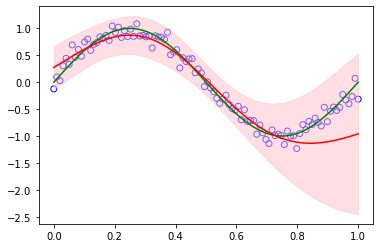

In [179]:
if (data.shape[1] == 1 and len(target.shape) == 1):

  x = torch.linspace(0,1,100)[:,None]
  mean = model(x).mean.detach().numpy()
  cr1, cr2 = model(x).confidence_region()
  cr1 = cr1.detach().numpy()
  cr2 = cr2.detach().numpy()
  from matplotlib import pyplot as plt


  plt.scatter(data, target, facecolor="none", edgecolor="b", color="blue", label="training")
  plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
  plt.plot(x, mean, color="r", label="gpr")
  plt.fill_between(torch.squeeze(x), cr1, cr2, alpha=0.5, color="pink", label="std")
  plt.show()